In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# for t-test precip. mean
from scipy.stats import ttest_ind

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
# data directoies
dir_mcs_env = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track')
dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/')

#### plotting functions 

In [120]:
def plot_BL_TOT(data_track, data_env_phase, subplots_ax, row_pos):
    
    data_track_sub = data_track.sel(tracks=track_number)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]

    # plot mcs binary mask
    for n, (ax, phase, idt) in enumerate(zip(subplots_ax, data_env_phase.mcs_phase.values,
                                            idt_phase)):
        
        ax.coastlines(color='k',linewidth=0.7)
        ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
        ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
        ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
        
        meanlon = data_track_sub.meanlon.isel(times=idt).values
       
        lon = data_track_sub.meanlon.isel(times=idt).values + np.linspace(-5,5,40)
        lat = data_track_sub.meanlat.isel(times=idt).values + np.linspace(-5,5,40)
        
        if meanlon < 0: # if negative in longitude
            lon = lon + 360
        else:
            lon = lon
        
        mcs_mask = data_env_phase.sel(mcs_phase = phase).cloudtracknumber_nomergesplit
        ax.contour(lon, lat, mcs_mask, linewidths=2, levels=[0,1], colors=['m'], zorder=2,
                  transform=ccrs.PlateCarree())
        
        BL_TOT_phase = data_env_phase.sel(mcs_phase = phase).Buoy_TOT

        cf = ax.pcolormesh(lon, lat, BL_TOT_phase, vmin=-0.12,vmax=0.02, cmap='jet',
                        zorder=1, transform=ccrs.PlateCarree())
        ax.contour(lon, lat, BL_TOT_phase, levels=[0,0.02], colors=['k'], linewidths=1,
                        zorder=2, transform=ccrs.PlateCarree())
        if n == 4:
            cbaxes = fig.add_axes([0.91, 0.55, 0.01, 0.3])              
            cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.7)
            cbar.set_label('Buoy. (m/s$^{2}$)')
             
        timestamp_phase = data_track.base_time.sel(tracks=track_number, times=idt).values
        ax.set_title('MCS phase: {}'.format(phase), fontsize=12, fontweight='bold')
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='k', alpha=0.4, linestyle=':')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

In [122]:
def plot_era5_gpm_rainrate(data_track, data_env_phase, subplots_ax, row_pos):
        
    data_track_sub = data_track.sel(tracks=track_number)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]
    
    # plot mcs binary mask
    for n, (ax, phase, idt) in enumerate(zip(subplots_ax, data_env_phase.mcs_phase.values,
                                        idt_phase)):
        
        ax.coastlines(color='k',linewidth=0.7)
        ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
        ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
        ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
        
        meanlon = data_track_sub.meanlon.isel(times=idt).values
        
        lon = data_track_sub.meanlon.isel(times=idt).values + np.linspace(-5,5,40)
        lat = data_track_sub.meanlat.isel(times=idt).values + np.linspace(-5,5,40)
        
        if meanlon < 0: # if negative in longitude
            lon = lon + 360
        else:
            lon = lon
            
        # MCS mask
        mcs_mask = data_env_phase.sel(mcs_phase = phase).cloudtracknumber_nomergesplit
        ax.contour(lon, lat, mcs_mask, linewidths=2, levels=[0,1], colors=['m'], zorder=2, 
                   transform=ccrs.PlateCarree())
        
        # ERA-5 precip
        pr_phase = data_env_phase.sel(mcs_phase = phase).mtpr # (mm/hr)
        # GPM-IMERG precip
        pr_gpm_phase = data_env_phase.sel(mcs_phase = phase).precipitationCal # (mm/hr)

        # ERA-5 rainrate (shading)
        pr_mask = pr_phase.where(pr_phase > 1) # larger than 1 mm/hr
        cf = ax.pcolormesh(lon, lat, pr_mask, cmap='jet', vmin=1, vmax=12,
                        transform=ccrs.PlateCarree())
        # GPM rainrate (contours)
        ax.contour(lon, lat, pr_gpm_phase, levels=[5], colors=['skyblue'], transform=ccrs.PlateCarree())
        ax.contour(lon, lat, pr_gpm_phase, levels=[10], colors=['r'], transform=ccrs.PlateCarree())
        
        if n == 4: # set colorbar on the far right 
            cbaxes = fig.add_axes([0.91, 0.14, 0.01, 0.3])              
            cbar = plt.colorbar(cf,cax=cbaxes, shrink=0.7)
            cbar.set_ticks([1,3,5,7,9,11])
            cbar.set_label('ERA5 rainrate (mm/hr)')
            
        timestamp_phase = data_track.base_time.sel(tracks=track_number, times=idt).values
        ax.set_title('{}'.format(str(timestamp_phase)[:13]), fontsize=12, fontweight='bold')
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='k', alpha=0.4, linestyle=':')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

#### Main codes: processing non2mcs data 

In [147]:
data_track.tracks[:10]

<xarray.DataArray 'tracks' (tracks: 10)>
array([ 30,  55,  59,  61,  84,  95, 120, 127, 161, 171])
Coordinates:
  * tracks   (tracks) int64 30 55 59 61 84 95 120 127 161 171

CPU times: user 581 ms, sys: 7.61 ms, total: 588 ms
Wall time: 757 ms


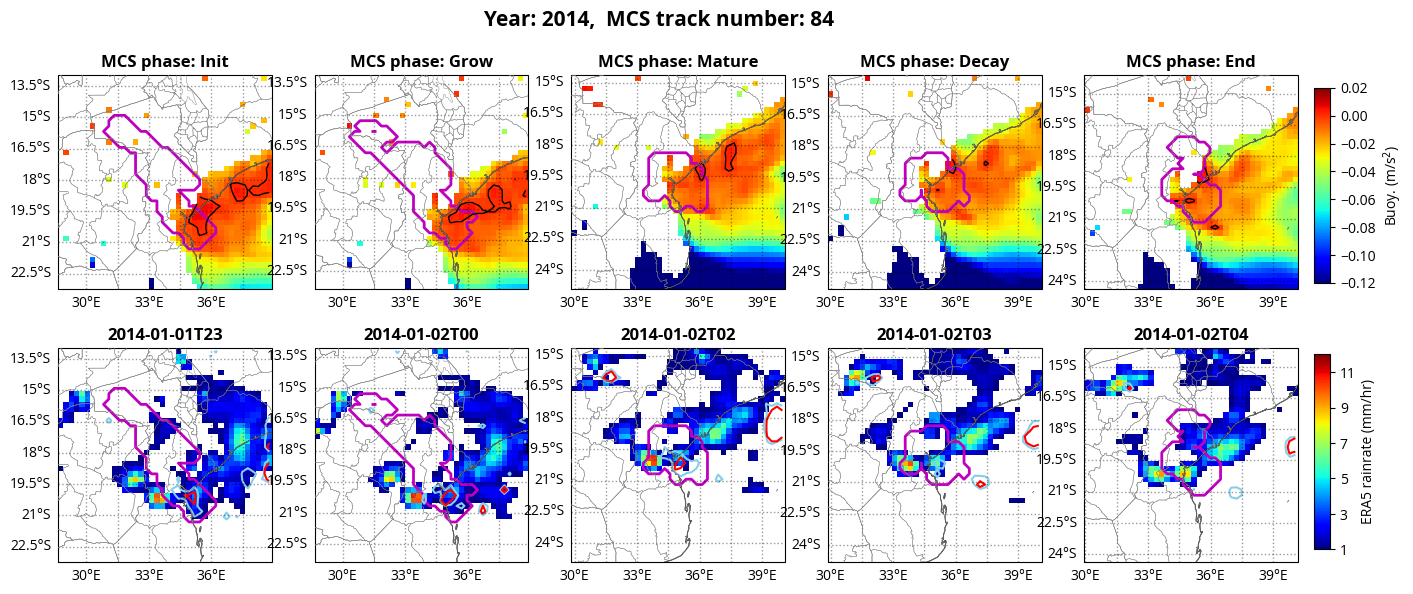

In [148]:
%%time
year = 2014

data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
dir_env_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))

# find selected MCS-env data with the ID accordingly
track_number = 84

data_env_phase = xr.open_dataset(dir_env_track / 'mcs_era5_3D_envs_{}.{}.LD.nc'.format(year,str(track_number).zfill(5)))

start_basetime = data_track.sel(tracks=track_number).start_basetime.values
timestamp_str = str(start_basetime)
year = timestamp_str[:4]
month = timestamp_str[5:7]
day = timestamp_str[8:10]
hour = timestamp_str[11:13]

# MCS initial time centroid
idt_init = data_track.sel(tracks=track_number).idt_mcs_init.values
meanlon = data_track.sel(tracks=track_number, times=idt_init).meanlon
meanlat = data_track.sel(tracks=track_number, times=idt_init).meanlat

if meanlon < 0: # if negative in longitude
    meanlon_era5 = meanlon + 360
else:
    meanlon_era5 = meanlon

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(16,6.5),
                                                                  subplot_kw={'projection': ccrs.PlateCarree()})
plot_BL_TOT(data_track, data_env_phase, [ax1,ax2,ax3,ax4,ax5], row_pos=1)
plot_era5_gpm_rainrate(data_track, data_env_phase, [ax6,ax7,ax8,ax9,ax10], row_pos=2)

plt.suptitle('Year: {},  MCS track number: {}'.format(year,data_track.sel(tracks=track_number).tracks.values,
                                                     ), fontsize=15, fontweight='bold', y=0.97);
#plt.tight_layout()